In [4]:
import pyspark
from pyspark.sql import SparkSession

# create SparkSession
spark = SparkSession.builder.master("local[*]") \
                	.appName('Spark') \
                	.getOrCreate()

# extract SparkContext
sc = spark.sparkContext

print('Spark is ready with CPU usage :', sc.defaultParallelism)

Exception: Java gateway process exited before sending its port number

## Récupération des csv

In [2]:
df_citibike = spark.read.option("header",True).csv("data/JC-202002-citibike-tripdata.csv")

df_tripdata = spark.read.option("header",True).csv("data/green_tripdata_2020-01.csv")

df_taxi_zone = spark.read.option("header",True).csv("data/taxi+_zone_lookup.csv")

## Analyse des données - Cycling in New York dataframe (citibike)

In [3]:
df_citibike.show()

+------------+--------------------+--------------------+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+--------------------+---------------------+------+----------+----------+------+
|tripduration|           starttime|            stoptime|start station id|  start station name|start station latitude|start station longitude|end station id|    end station name|end station latitude|end station longitude|bikeid|  usertype|birth year|gender|
+------------+--------------------+--------------------+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+--------------------+---------------------+------+----------+----------+------+
|         841|2020-02-01 00:02:...|2020-02-01 00:16:...|            3199|        Newport Pkwy|            40.7287448|            -74.0321082|          3213|      Van Vorst Park|         40.71848892|        -74.047726625| 42217|Su

In [17]:
# Get most frequent trips itineraries
df_citibike.createOrReplaceTempView("citibike")

df_station = spark.sql("SELECT `start station name`, `end station name`, COUNT(`start station name`) AS number FROM citibike GROUP BY `start station name`, `end station name` ORDER BY number desc")

#df_station.show()

In [5]:
# Get average duration by age and gender
# gender : Zero=unknown; 1=male; 2=female
df_mean_duration = spark.sql("SELECT `birth year`, gender, AVG(`tripduration`) AS avg_duration FROM citibike GROUP BY `birth year`, gender ORDER BY avg_duration desc")

#df_mean_duration.show()

In [6]:
# Get number of trips by user type
# User Type : Customer = 24-hour pass or 3-day pass user; Subscriber = Annual Member
df_nb_trips = spark.sql("SELECT usertype, COUNT(usertype) AS nb_trips FROM citibike GROUP BY usertype ORDER BY nb_trips desc")

#df_nb_trips.show()

In [7]:
# Get hours when there are the most trips
df = spark.sql("SELECT starttime FROM citibike")

df_starttime_hours = spark.sql("SELECT hour(starttime) AS hour, COUNT(hour(starttime)) AS nb_trips FROM citibike GROUP BY hour ORDER BY nb_trips desc")

#df_starttime_hours.show()

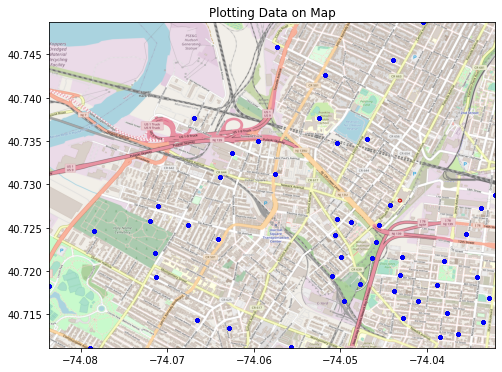

In [8]:
# Plot start stations on map
import matplotlib.pyplot as plt

df_geo = spark.sql("SELECT `start station latitude`, `start station longitude` FROM citibike")

df_geo_pd = df_geo.toPandas()

df_geo_pd['start station latitude'] = df_geo_pd['start station latitude'].astype(float)
df_geo_pd['start station longitude'] = df_geo_pd['start station longitude'].astype(float)

BBox = ((df_geo_pd['start station longitude'].min(),  df_geo_pd['start station longitude'].max(),      
         df_geo_pd['start station latitude'].min(), df_geo_pd['start station latitude'].max()))

ny_map = plt.imread('map.png')


fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(df_geo_pd['start station longitude'], df_geo_pd['start station latitude'], zorder=1, alpha= 0.2, c='b', s=10)
ax.set_title('Plotting Data on Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ny_map, zorder=0, extent = BBox, aspect= 'equal')


## Création d'un dataframe plus léger

In [110]:
df_citibike.show()

+------------+--------------------+--------------------+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+--------------------+---------------------+------+----------+----------+------+
|tripduration|           starttime|            stoptime|start station id|  start station name|start station latitude|start station longitude|end station id|    end station name|end station latitude|end station longitude|bikeid|  usertype|birth year|gender|
+------------+--------------------+--------------------+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+--------------------+---------------------+------+----------+----------+------+
|         841|2020-02-01 00:02:...|2020-02-01 00:16:...|            3199|        Newport Pkwy|            40.7287448|            -74.0321082|          3213|      Van Vorst Park|         40.71848892|        -74.047726625| 42217|Su

In [64]:
df_citibike = df_citibike[['tripduration', 'starttime', 'start station latitude', 'start station longitude']]

## Analyse des données - Taxis in New York dataframe (trip record)

In [3]:
df_tripdata.show()

+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+---------+--------------------+
|VendorID|lpep_pickup_datetime|lpep_dropoff_datetime|store_and_fwd_flag|RatecodeID|PULocationID|DOLocationID|passenger_count|trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|ehail_fee|improvement_surcharge|total_amount|payment_type|trip_type|congestion_surcharge|
+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+---------+--------------------+
|       2| 2019-12-18 15:52:30|  2019-12-18 15:54:39|                 N|         1|         264|         264|              5|          .00|        3.5|  0.5|    0.

In [9]:
df_taxi_zone.show()

+----------+-------------+--------------------+------------+
|LocationID|      Borough|                Zone|service_zone|
+----------+-------------+--------------------+------------+
|         1|          EWR|      Newark Airport|         EWR|
|         2|       Queens|         Jamaica Bay|   Boro Zone|
|         3|        Bronx|Allerton/Pelham G...|   Boro Zone|
|         4|    Manhattan|       Alphabet City| Yellow Zone|
|         5|Staten Island|       Arden Heights|   Boro Zone|
|         6|Staten Island|Arrochar/Fort Wad...|   Boro Zone|
|         7|       Queens|             Astoria|   Boro Zone|
|         8|       Queens|        Astoria Park|   Boro Zone|
|         9|       Queens|          Auburndale|   Boro Zone|
|        10|       Queens|        Baisley Park|   Boro Zone|
|        11|     Brooklyn|          Bath Beach|   Boro Zone|
|        12|    Manhattan|        Battery Park| Yellow Zone|
|        13|    Manhattan|   Battery Park City| Yellow Zone|
|        14|     Brookly

In [5]:
df_tripdata.createOrReplaceTempView("tripdata")

# Get average price by type of trip

df_avg_price = spark.sql("SELECT RateCodeID, AVG(Total_amount) AS avg_price FROM tripdata GROUP BY RateCodeID ORDER BY avg_price desc ")

#df_avg_price.show()

In [8]:
df_avg_tip_amount = spark.sql("SELECT passenger_count, AVG(tip_amount) AS avg_tip FROM tripdata GROUP BY passenger_count ORDER BY passenger_count ")

df_avg_tip_amount.show()

+---------------+--------------------+
|passenger_count|             avg_tip|
+---------------+--------------------+
|           null|0.004600132700278324|
|              0|  0.9793096646942802|
|              1|  1.2073233378481214|
|              2|  1.2610531643519471|
|              3|  1.0686510204081632|
|              4|   1.203604806408545|
|              5|  1.3197287145242067|
|              6|  1.2611229611041406|
|              7|  0.7299999999999999|
|              8|   2.376153846153846|
|              9|                0.93|
+---------------+--------------------+



## Création d'un dataframe plus léger

In [107]:
df_tripdata = df_tripdata[['lpep_pickup_datetime', 'PULocationID', 'DOLocationID', 'trip_distance', 'total_amount']]

## Corrélation entre les deux datasets

In [38]:
# Get hours when there are the most bike trips
df_starttime_bike_hours = spark.sql("SELECT hour(starttime) AS hour, COUNT(hour(starttime)) AS nb_trips FROM citibike GROUP BY hour ORDER BY hour")


# Get hours when there are the most taxi trips
df_starttime_taxi_hours = spark.sql("SELECT hour(lpep_pickup_datetime) AS hour, COUNT(hour(lpep_pickup_datetime)) AS nb_trips FROM tripdata GROUP BY hour ORDER BY hour")

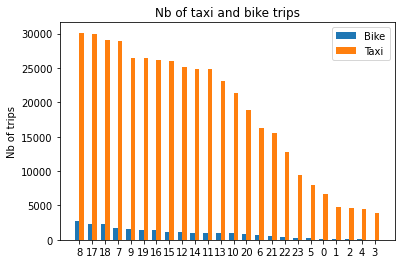

In [37]:
import matplotlib.pyplot as plt
import numpy as np

hours_labels = df_starttime_bike_hours.select("hour").rdd.flatMap(lambda x: x).collect()
bike_trips = df_starttime_bike_hours.select("nb_trips").rdd.flatMap(lambda x: x).collect()
taxi_trips = df_starttime_taxi_hours.select("nb_trips").rdd.flatMap(lambda x: x).collect()

x = np.arange(len(hours_labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, bike_trips, width, label='Bike')
rects2 = ax.bar(x + width/2, taxi_trips, width, label='Taxi')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Nb of trips')
ax.set_title('Nb of taxi and bike trips')
ax.set_xticks(x)
ax.set_xticklabels(hours_labels)
ax.legend()


plt.show()

In [9]:
import geopandas
import pandas as pd

In [10]:
# Convert pyspark dataframe to pandas dataframe and map id to borough

df_location = spark.sql("SELECT PULocationID, DOLocationID FROM tripdata")

df_location = df_location.toPandas()

dict_ = df_taxi_zone.toPandas()['Borough'].to_dict()

df_location.PULocationID = df_location.PULocationID.astype(int)

df_location = df_location.replace({"PULocationID": dict_})

In [11]:
# Get latitude and longitude from geopandas dataset
boros = geopandas.read_file(geopandas.datasets.get_path("nybb"))

boro_locations = geopandas.tools.geocode(boros.BoroName)

boro_locations['lon'] = boro_locations.geometry.x
boro_locations['lat'] = boro_locations.geometry.y

In [12]:
# Formatting boroughs
boro_locations['address'] = boro_locations['address'].apply(lambda x: x.split(',')[0])

boro_locations['address'] = boro_locations['address'].apply(lambda x: x.split(' ')[0] if (x == 'Bronx County' or x == 'Queens County')  else x)

In [13]:
df_ny = pd.merge(boro_locations,df_location, how='right', left_on='address',right_on='PULocationID')

In [14]:
df_ny.dropna(inplace=True)

In [15]:
df_ny = df_ny[0:100]

In [18]:
df_bike_location = spark.sql("SELECT `start station latitude`, `start station longitude` FROM citibike")

df_bike_location = df_bike_location.toPandas()

In [19]:
df_bike_location = df_bike_location[0:100]

In [34]:
df_ny = df_ny[['lat', 'lon']]

df_bike_location.columns = ['lat', 'lon']

df_geo = pd.concat([df_bike_location, df_ny], ignore_index=True)

In [97]:
import folium
from folium import features
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster

In [105]:
map_wb = folium.Map(location=[40.742459, -73.971765],zoom_start=12)#, tiles='Active nightlife zone')
mc = MarkerCluster()
for ind,row in df_geo.iterrows():
    mc.add_child(folium.CircleMarker(location=[row['lat'],row['lon']],
                        radius=1,color='#3185cc'))
    
map_wb.add_child(mc)
map_wb